In [1]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(5, 5)
plt.rcParams['figure.dpi'] = 150
sc.settings.verbosity = 3
sc.logging.print_versions()
#results_file = './write/results.h5ad'


%load_ext autoreload
%autoreload 2 

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
import rpy2.rinterface_lib.callbacks
import logging
import warnings
from rpy2.robjects import pandas2ri
import anndata2ri


# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
#library(RColorBrewer)
#library(slingshot)
#library(monocle)
#library(gam)
#library(clusterExperiment)
#library(ggplot2)
#library(plyr)
library(MAST)

In [4]:
adata = sc.read('./data/data_merged.h5ad')

In [5]:
adata = adata[adata.obs['baseline'] == 'BL']

# Dataloading

In [6]:
print(adata.obs['adult_stress'].value_counts())
print('')

Stress    9129
Ctrl      8947
Name: adult_stress, dtype: int64



In [7]:
adata.X = adata.X.toarray()

# QC

In [8]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

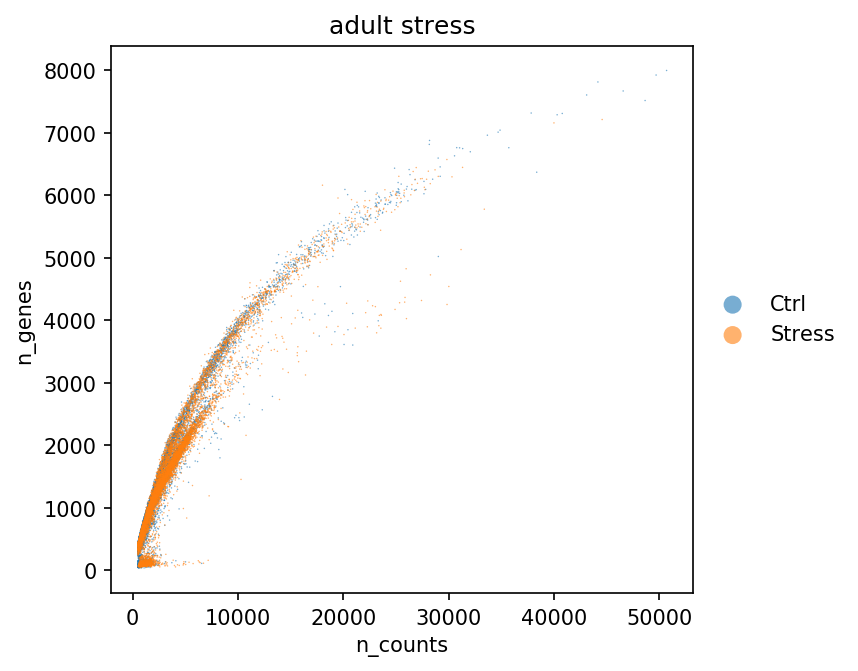

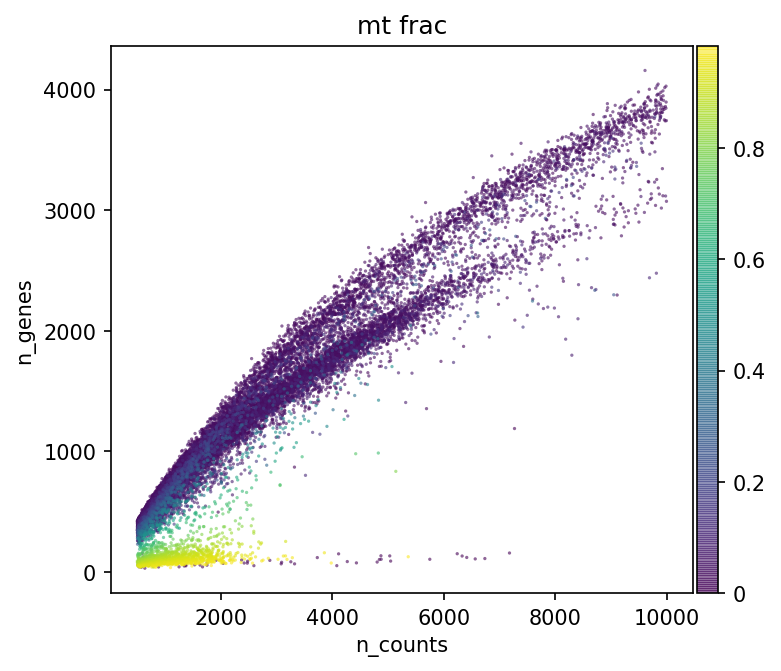

In [9]:
#Data quality summary plots
#plt.rcParams['figure.figsize'] = (10, 10)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', size=2, color='adult_stress', alpha=0.6)
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=10, alpha=0.6)

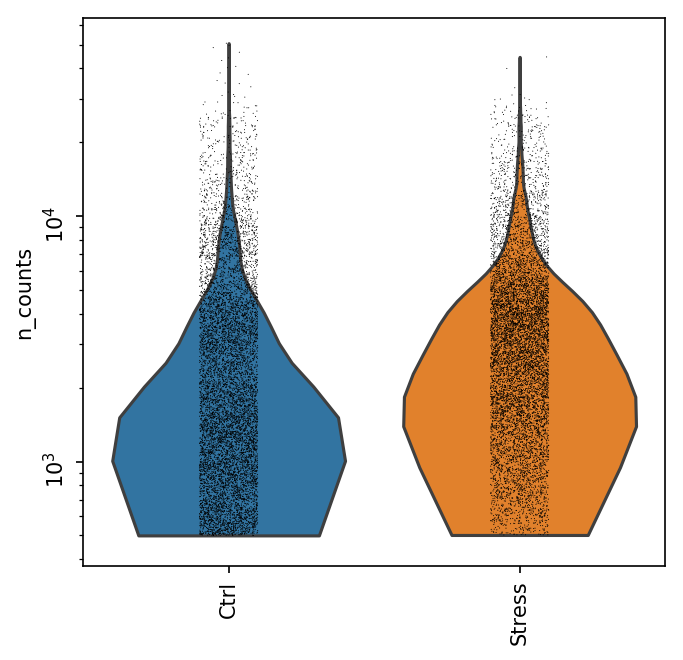

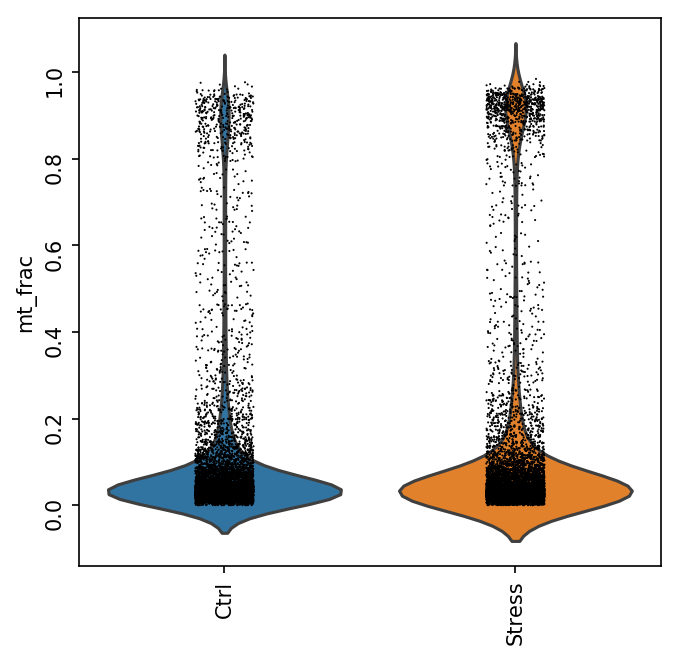

In [10]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='adult_stress', size=0.5, log=True, cut=0, rotation=90)
t4 = sc.pl.violin(adata, 'mt_frac', groupby='adult_stress', rotation=90)
#t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample')

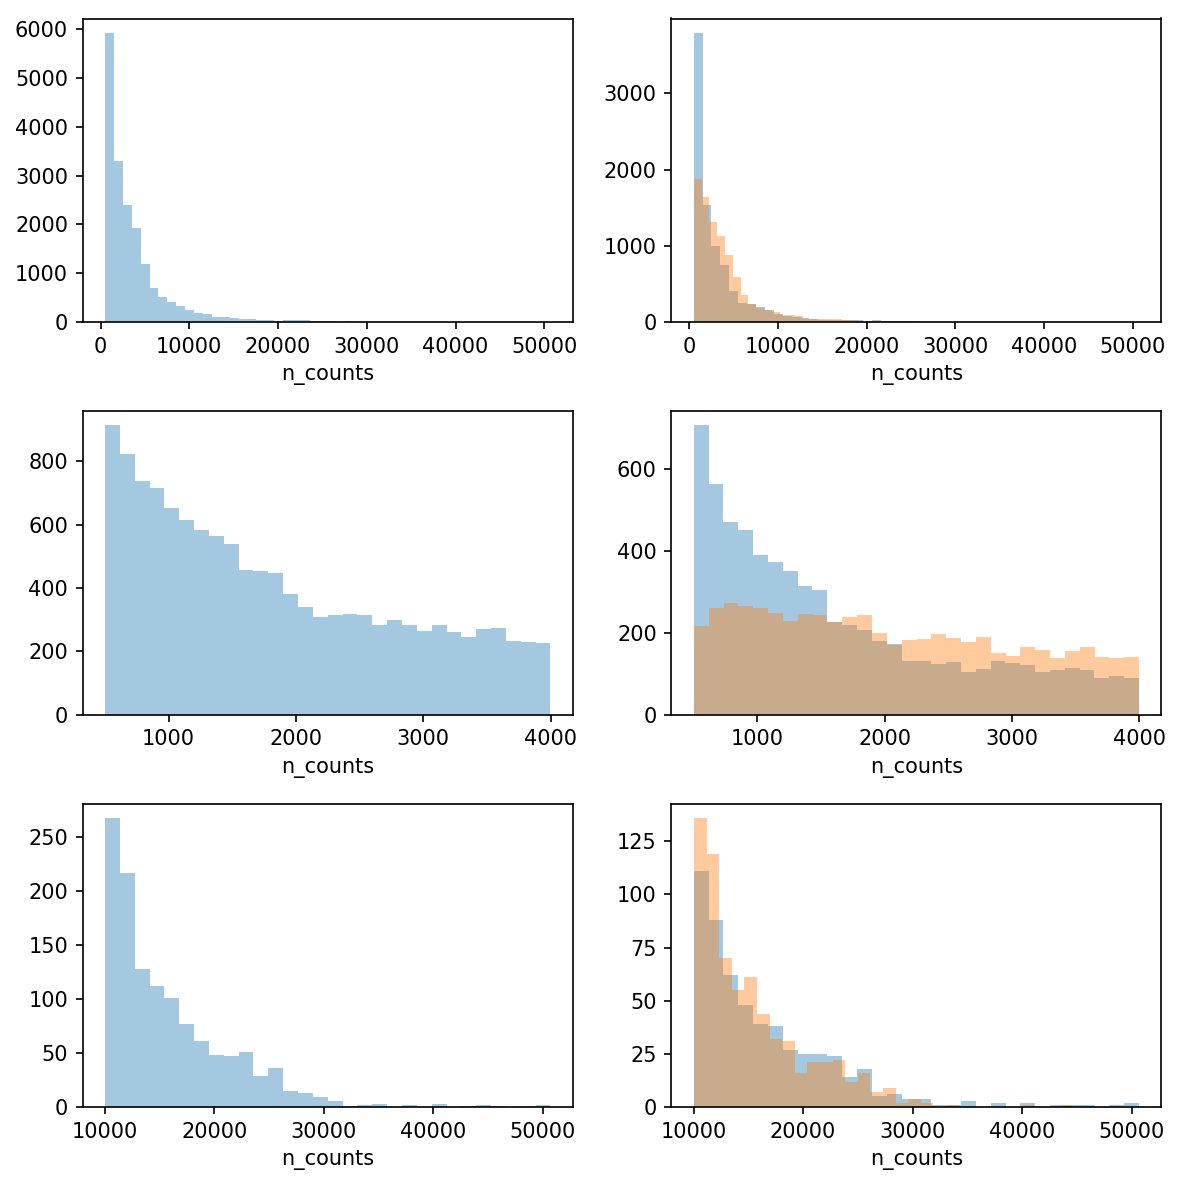

In [11]:
#Thresholding decision: counts
fig, ax = plt.subplots(3, 2, figsize=(8, 8))
sns.distplot(adata.obs['n_counts'], kde=False, ax=ax[0, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['adult_stress']=='Ctrl'], kde=False, ax=ax[0, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['adult_stress']=='Stress'], kde=False, ax=ax[0, 1])

sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=30, ax=ax[1, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['adult_stress']=='Ctrl'][adata.obs['n_counts']<4000], kde=False, bins=30, ax=ax[1, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['adult_stress']=='Stress'][adata.obs['n_counts']<4000], kde=False, bins=30, ax=ax[1, 1])

sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['adult_stress']=='Ctrl'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['adult_stress']=='Stress'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 1])
fig.tight_layout()

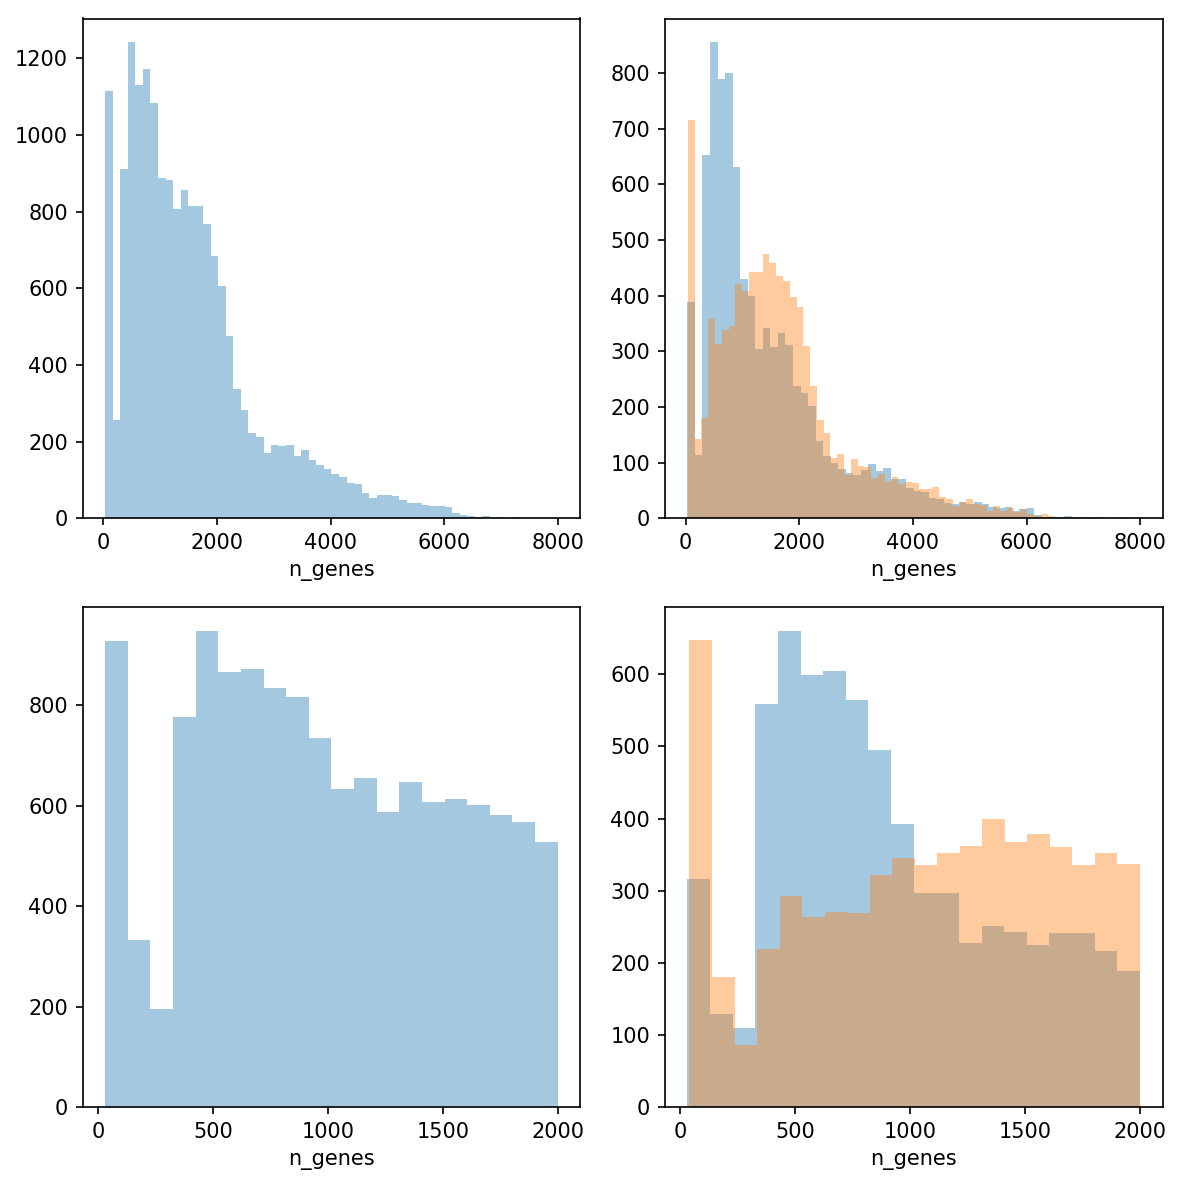

In [12]:
#Thresholding decision: genes
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.distplot(adata.obs['n_genes'], kde=False, bins=60, ax=ax[0, 0])
sns.distplot(adata.obs['n_genes'][adata.obs['adult_stress']=='Ctrl'], kde=False, bins=60, ax=ax[0, 1])
sns.distplot(adata.obs['n_genes'][adata.obs['adult_stress']=='Stress'], kde=False, bins=60, ax=ax[0, 1])

sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 0])
sns.distplot(adata.obs['n_genes'][adata.obs['adult_stress']=='Ctrl'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 1])
sns.distplot(adata.obs['n_genes'][adata.obs['adult_stress']=='Stress'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 1])
fig.tight_layout()

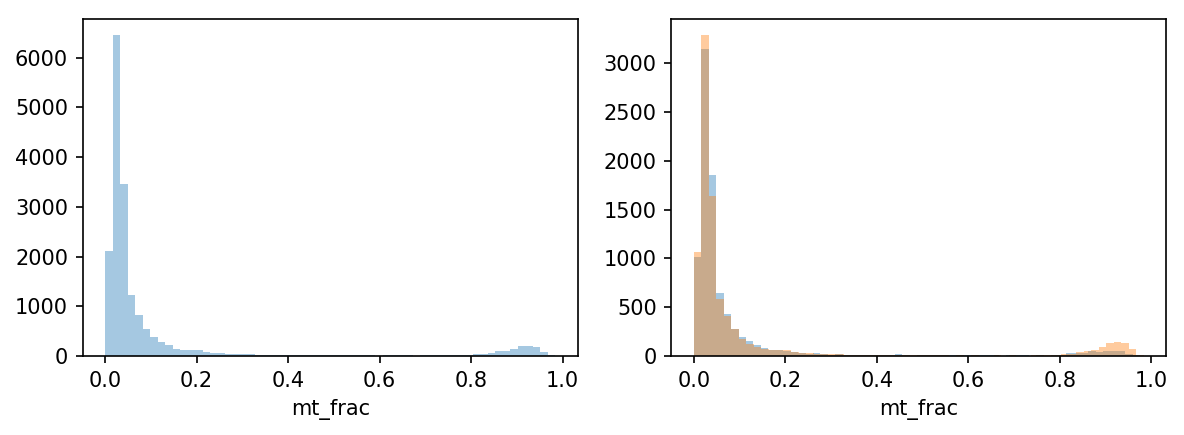

In [13]:
#Thresholding decision: genes
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=ax[0])
sns.distplot(adata.obs['mt_frac'][adata.obs['adult_stress']=='Ctrl'], kde=False, bins=60, ax=ax[1])
sns.distplot(adata.obs['mt_frac'][adata.obs['adult_stress']=='Stress'], kde=False, bins=60, ax=ax[1])
fig.tight_layout()

In [14]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

#sc.pp.filter_cells(adata, max_counts = 45000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.25]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 400)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 18076
Number of cells after min count filter: 18076
Number of cells after MT filter: 16184
filtered out 543 cells that haveless than 400 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 15641


In [15]:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31538
filtered out 14938 genes that are detectedin less than 20 cells
Number of genes after cell filter: 16600


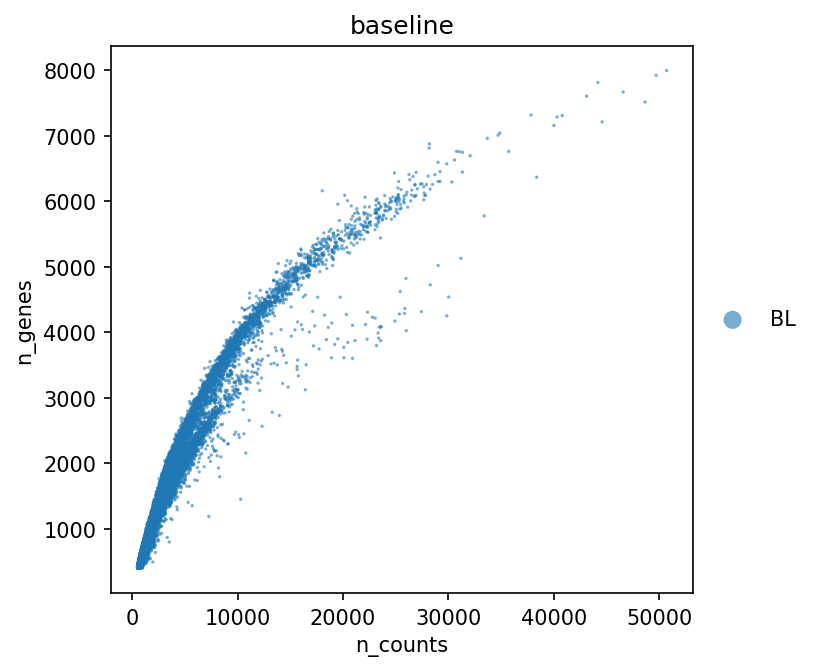

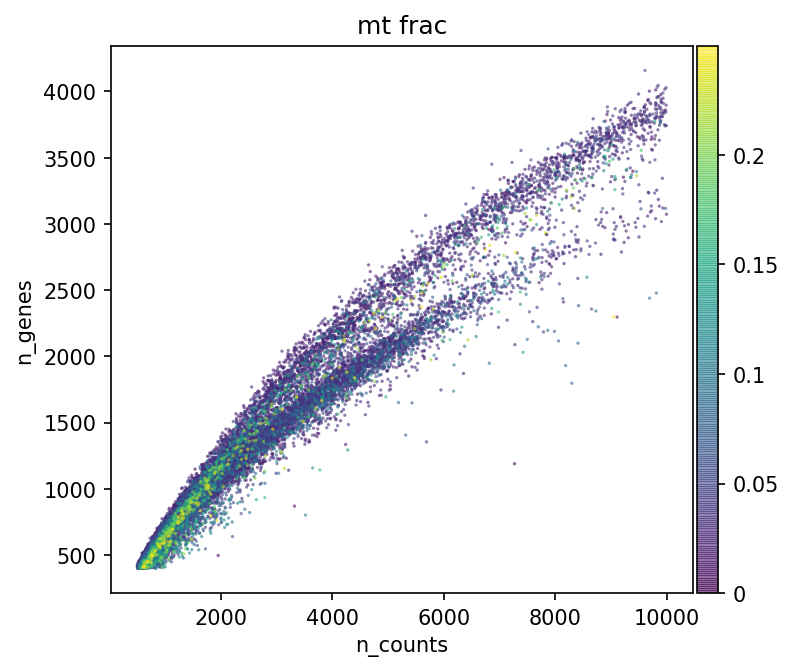

In [16]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', size=10, color='baseline', alpha=0.6)
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=10, alpha=0.6)

In [17]:
import scrublet as scr
scrub = scr.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata.obs['doublet_scores'] = doublet_scores
adata.obs['predicted_doublets'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 46.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.2%
Elapsed time: 20.8 seconds


(<Figure size 1200x450 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x145b126d0>,
       dtype=object))

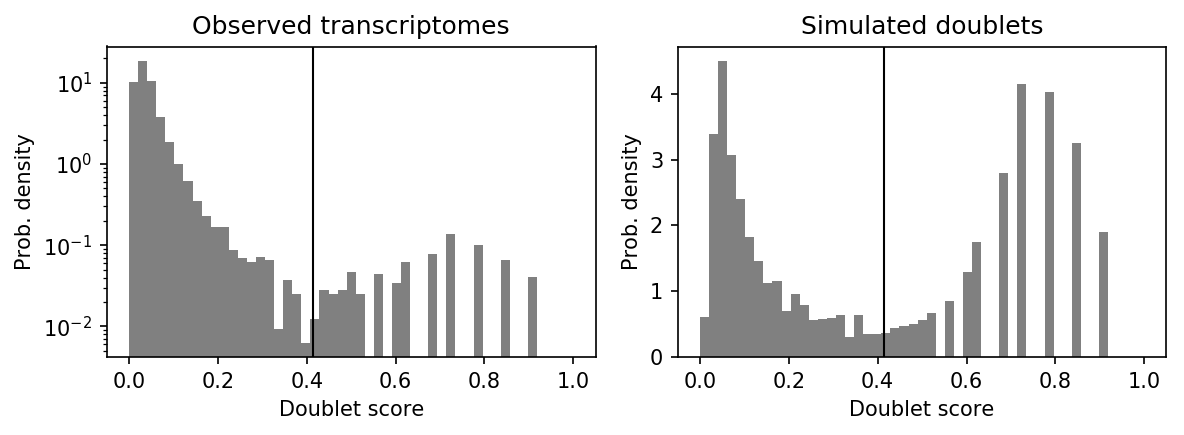

In [18]:
scrub.plot_histogram()

In [19]:
adata = adata[~adata.obs['predicted_doublets']]
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells after doublet filter: 15412


# Normalization

In [20]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 15


/Users/carlo.dedonno/Library/Python/3.7/lib/python/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../Library/Python/3.7/lib/python/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/carlo.dedonno/Library/Python/3.7/lib/python/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../Library/Python/3.7/lib/py

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


In [21]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [22]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Trying to set attribute `.obs` of view, making a copy.


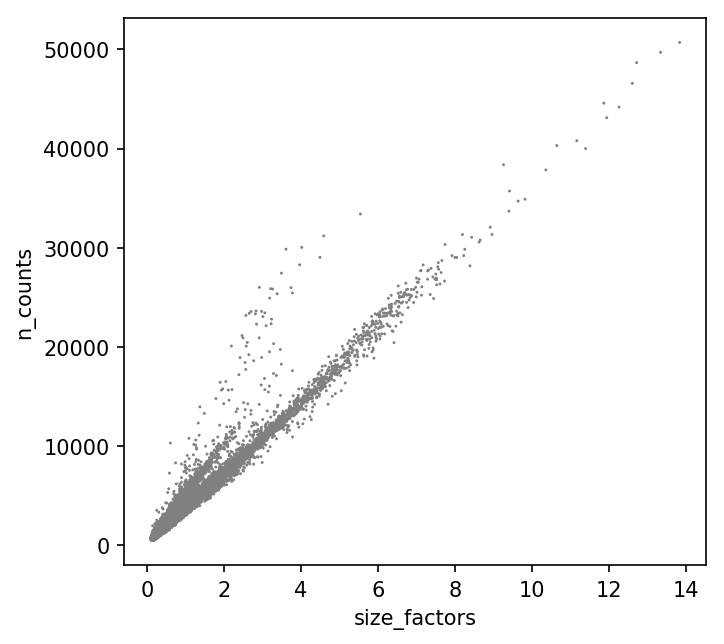

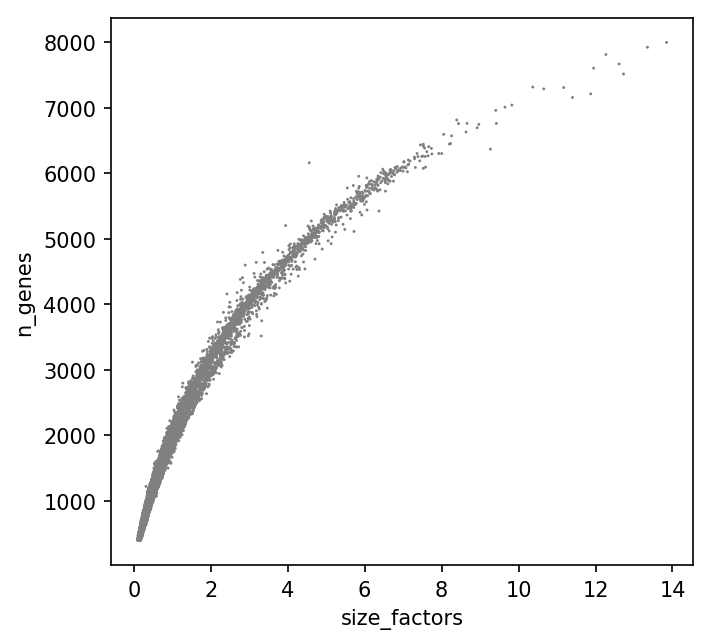

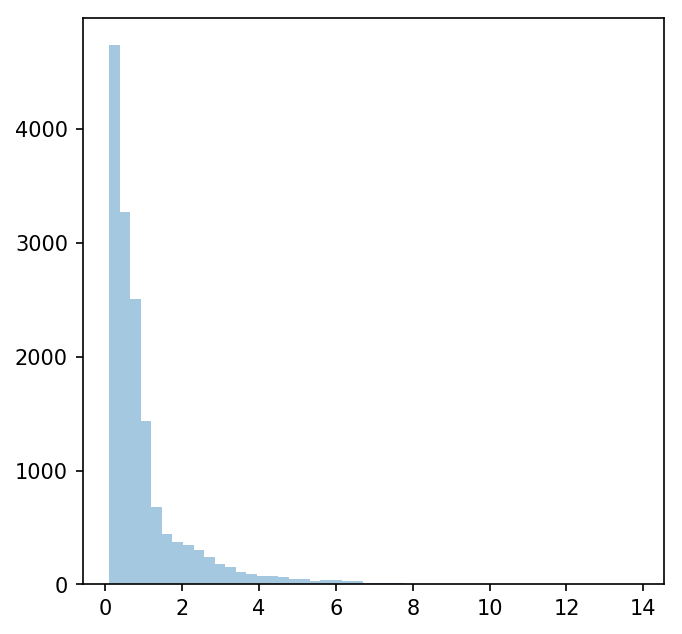

In [23]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sns.distplot(size_factors, bins=50, kde=False)
plt.show()

In [24]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [25]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [26]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

# Batch correction

In [27]:
# ComBat batch correction
sc.pp.combat(adata, key='adult_stress')

Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/Users/carlo.dedonno/Library/Python/3.7/lib/python/site-packages/scanpy/preprocessing/_combat.py:269: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_it_sol" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'sum2', defined at /Users/carlo.dedonno/Library/Python/3.7/lib/python/site-packages/scanpy/preprocessing/_combat.py (311)

File "../../Library/Python/3.7/lib/python/site-packages/scanpy/preprocessing/_combat.py", line 311:
def _it_sol(s_data, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001) -> Tuple[float, float]:
    <source elided>
        g_new = (t2*n*g_hat + d_old*g_bar) / (t2*n + d_old)
        sum2 = s_data - g_new.reshape((g_new.shape[0], 1)) @ np.ones((1, s_data.shape[1]))
        ^

[1] During: typing of assignment at /Users/carlo.dedonno/Library/Python/3.7/lib/python/site-packages/scanpy/preprocessing/_combat.py (313)

File "../../Library/Python/3.7/lib/python/site-packages/scan

Adjusting data



# HVG

In [27]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


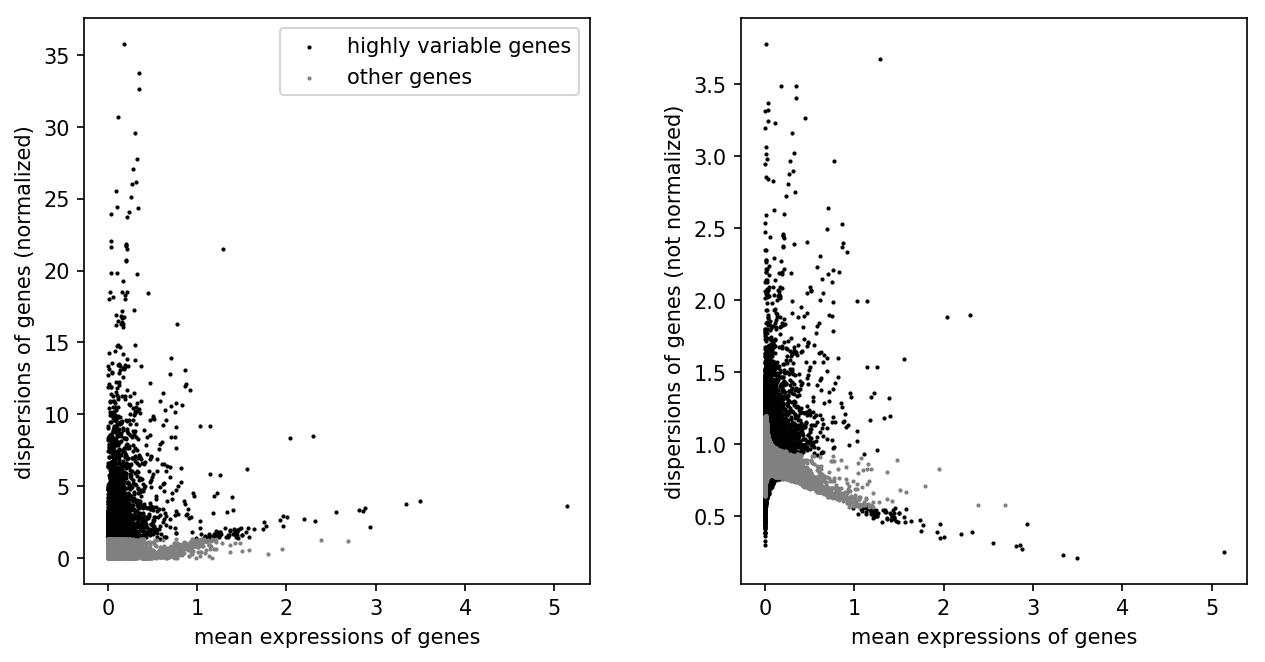

In [28]:
sc.pl.highly_variable_genes(adata)

# Visualization

In [29]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

#sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
#sc.tl.diffmap(adata)
#sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/carlo.dedonno/Library/Python/3.7/lib/python/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../Library/Python/3.7/lib/python/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


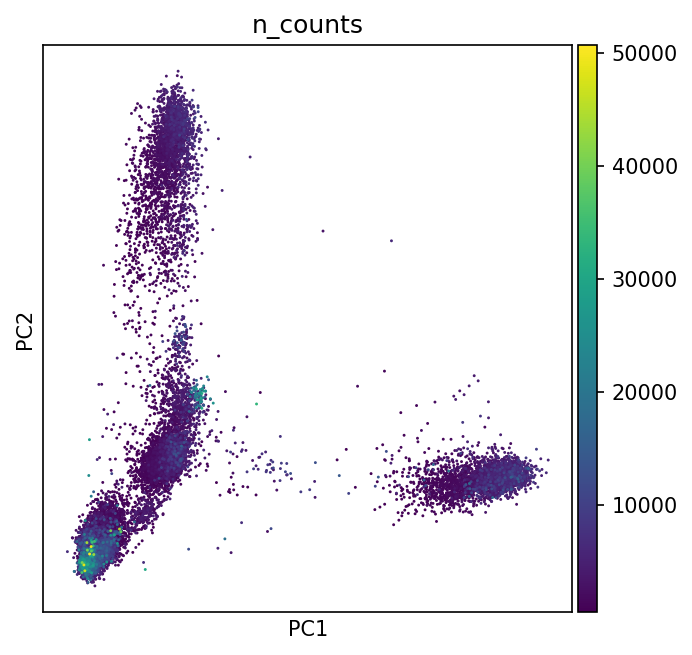

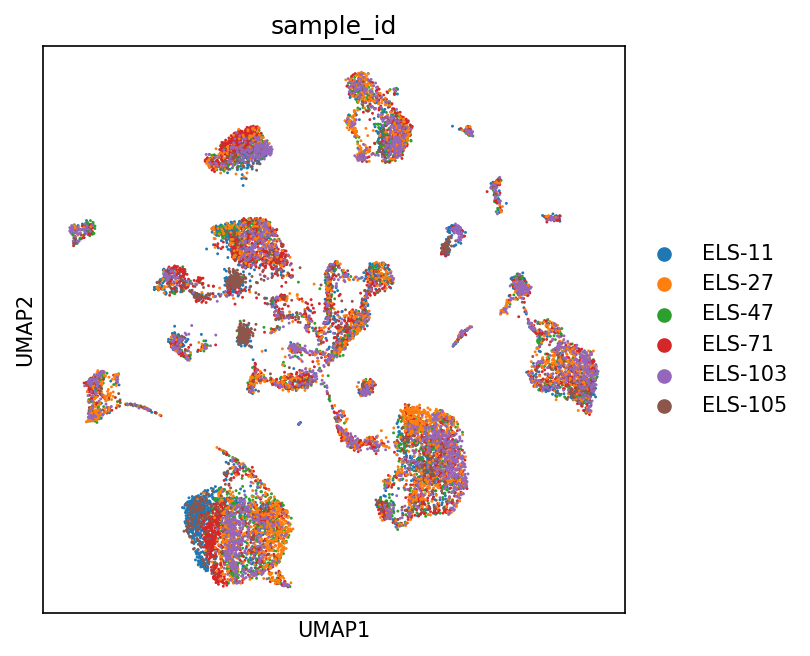

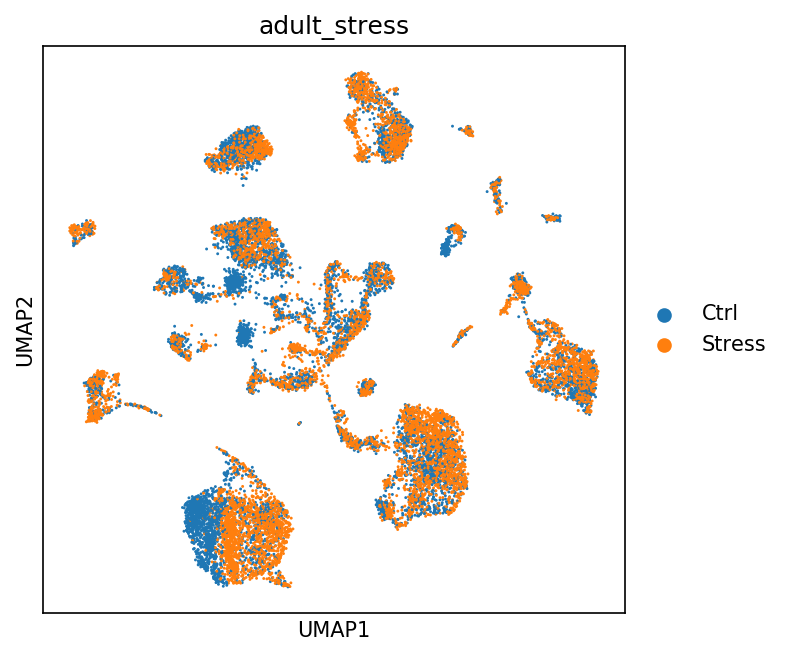

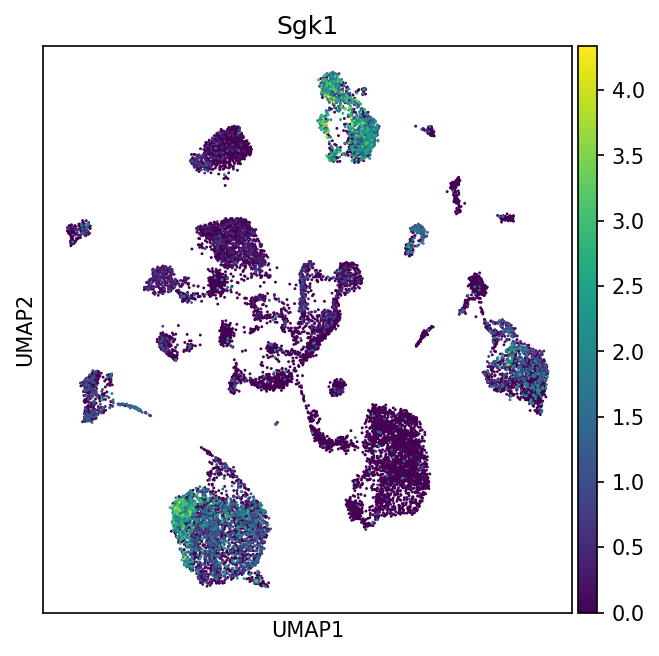

In [30]:
sc.pl.pca_scatter(adata, color='n_counts')
#sc.pl.tsne(adata, color='n_counts')
sc.pl.umap(adata, color='sample_id', save='_nobatchcorr_sample.png')
sc.pl.umap(adata, color='adult_stress', save='_nobatchcorr_stress.png')
sc.pl.umap(adata, color='Sgk1')
#sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
#sc.pl.draw_graph(adata, color='n_counts')

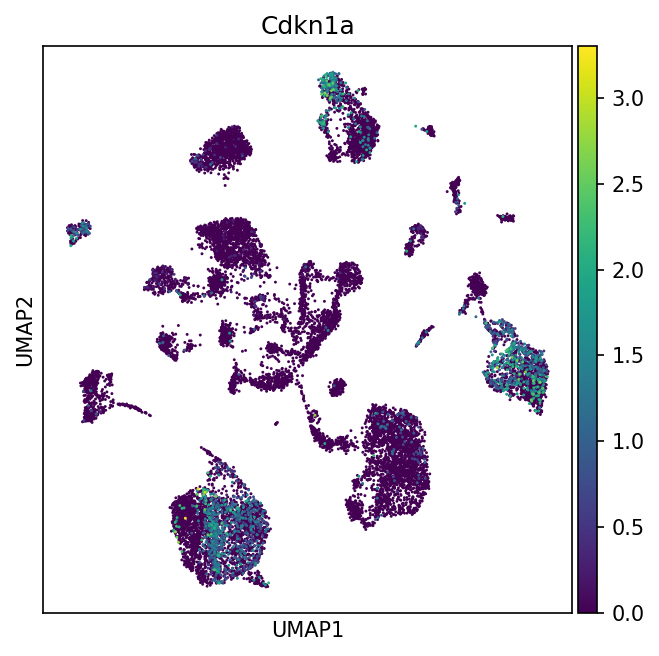

In [34]:
sc.pl.umap(adata, color='Cdkn1a')

In [ ]:
adata.write('./results/adata_n.h5ad')

# Cell cycle scoring

In [ ]:
#Score cell cycle and visualize the effect:
cc_genes_file = '../MRGR_Stress/Macosko_cell_cycle_genes.txt'
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

In [ ]:
sc.pl.umap(adata, color=['S_score', 'G2M_score'], use_raw=False)
sc.pl.umap(adata, color='phase', use_raw=False)

# Analysis

In [ ]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

In [ ]:
adata.obs['louvain_r0.5'].value_counts()

In [ ]:
#Visualize the clustering and how this is reflected by different technical covariates
plt.rcParams['figure.figsize'] = (8, 8)
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], size=15, palette=sc.pl.palettes.default_64, save='clusters.png')
sc.pl.umap(adata, color=['condition'], size=15, save='conditions.png')
sc.pl.umap(adata, color=['n_counts', 'log_counts', 'mt_frac'], size=15, save='technical_vars.png')

# Marker genes

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

In [ ]:
writer = pd.ExcelWriter('adrenal_r1_markers.xlsx', engine='xlsxwriter')
names = adata.uns['rank_genes_r1']['names']
scores = adata.uns['rank_genes_r1']['scores']
foldchanges = adata.uns['rank_genes_r1']['logfoldchanges']
for clust in adata.obs['louvain_r1'].cat.categories:
        pd.DataFrame({'Names':names[clust], 'Scores':scores[clust], 'Log2foldchanges':foldchanges[clust]}).to_excel(writer,sheet_name=clust)
writer.save()

del scores, names, writer, foldchanges, clust

In [ ]:
adata.obs['louvain_r1'].unique()[1:3]

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata, groups=['Zona Fasciculata 1', 'Zona Fasciculata 2'], \
                               key='rank_genes_r1')

In [ ]:
#Plot marker genes
n_groups=16
fig, ax = plt.subplots(5, 1)
j = 0
for i in np.arange(0, n_groups, 3):
    ax[0, j] = sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=[adata.obs['louvain_r1'].unique()[i],\
                                                            adata.obs['louvain_r1'].unique()[i+1],\
                                                            adata.obs['louvain_r1'].unique()[i+2]], fontsize=12, show=False)
    j += 1

In [ ]:
adata.obs['louvain_r1'].unique()

In [ ]:
marker_genes = dict()
filepath = './data/adrenal_markers.txt'
with open(filepath) as fp:
    for cnt, line in enumerate(fp):
        if cnt > 0:
            gene, cell= line.split('\t')
            cell = cell.rstrip('\n')
            print(gene, cell)
            if cell not in set(marker_genes.keys()):
                marker_genes[cell] = [gene]
            else:
                marker_genes[cell].append(gene)

In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r1')
cell_annotation

In [ ]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r1', normalize='reference')
sns.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [ ]:
adata.rename_categories('louvain_r1', ['Transition 1', 'Macrophages', 'Zona Glomerulosa 1', 'Zona Fasciculata 5',\
                                         'Zona Fasciculata 3', 'Endothelial', 'Zona Fasciculata 2', 'Zona Glomerulosa 2',\
                                         'Transition 2', 'Zona Fasciculata 1', 'Macrophages 2', 'Medulla',\
                                         'Cycling', 'Unknown', 'Capsular Cells', 'Zona Fasciculata 4'])

In [ ]:
adata.obs['louvain_r1'].value_counts()

In [ ]:
plt.rcParams['figure.figsize']=(8, 8)
sc.pl.umap(adata, color='louvain_r1', size=15, legend_loc='on data')
sc.pl.draw_graph(adata, color='louvain_r1', size=15, legend_loc='on data')

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.pca_overview(adata)

In [ ]:
adata.obs['louvain_r1'] = adata.obs['louvain_r1'].cat.rename_categories(['Transition 1', 'Macrophages 1', 'Glomerulosa 1', 'Fasciculata 5', 'Fasciculata 3', 'Endothelial', 'Fasciculata 2', 'Glomerulosa 2',\
                                              'Transition 2', 'Fasciculata 1', 'Macrophages 2', 'Medulla', 'Cycling', 'Blood Cells', 'Capsular Cells', 'Fasciculata 4'])

In [ ]:
adata.obs['louvain_r1'] = adata.obs['louvain_r1'].cat.reorder_categories(['Fasciculata 1', 'Fasciculata 2', 'Fasciculata 3', 'Fasciculata 4', 'Fasciculata 5', 'Glomerulosa 1',\
                                               'Transition 1', 'Glomerulosa 2', 'Transition 2', 'Cycling', 'Capsular Cells', 'Medulla', 'Macrophages 1', 'Macrophages 2',\
                                               'Endothelial', 'Blood Cells'])

In [ ]:
sc.pl.dotplot(adata, var_names=['Mgarp', 'Cyp11a1', 'Cyp11b1', 'Agtr1a', 'Wnt4', 'Top2a', 'Sparcl1', 'Col1a2', 'Chgb', 'C1qc', 'Plvap', 'Tmsb10'], groupby='louvain_r1', dendrogram=False, save='_adrenal.svg')

In [ ]:
adata.write('./results/adrenal_renamed.h5ad')

In [ ]:
from rpy2 import robjects
def mast_de_groups(adata, groupby, save):
    '''Compute differential expression with the MAST package by treatment covariate within clusters provided as "groupby" and export as excel file'''
    
    #if groupby not in ['louvain_final', 'louvain_three']:
    #    raise NotImplementedError("This function is only implemented to be used with 'louvain_final' and 'louvain_three' group labels")
    
    # Define R function to run MAST analysis
    robjects.r('''
        mast_de_r <- function(adata, obs, var, clusters, groupby){
            #Prepare data sets for SingleCellExperiment data structure conversion
            #obs['wellKey'] = row.names(obs)
            #var['primerid'] = row.names(var)
            print('Deploying to R...')
            #Convert to SingleCellExperiment type
            #sca <- FromMatrix(exprsArray=data_mat, fData=var)
            sca <- SceToSingleCellAssay(adata, class = "SingleCellAssay")
            #Compute Gene detection rate
            colData(sca)$n_genes = scale(colData(sca)$n_genes)

            #Create a vector that will hold all the DE results
            output <- vector("list", length(clusters))

            count <- 0
            print('Begin computation...')
            #Loop over all louvain clusters
            for (i in clusters){
                count <- count+1
                print(i)
                #Create data subsets which should be used for testing
                if (groupby=='louvain_final') {
                    sca_sub <- subset(sca, with(colData(sca), louvain_final==i))
                } else if (groupby=='louvain_r1') {
                    sca_sub <- subset(sca, with(colData(sca), louvain_r1==i))
                } else {
                    stop()
                }

                #Filter out non-expressed genes in the subset
                sca_sub <- sca_sub[rowSums(assay(sca_sub)) != 0, ]

                #Define & run hurdle model
                zlmCond <- zlm(formula = ~condition + n_genes, sca=sca_sub)
                summaryCond <- summary(zlmCond, doLRT='conditionStress')

                summaryDt <- summaryCond$datatable

                result <- merge(summaryDt[contrast=='conditionStress' & component=='H',.(primerid, `Pr(>Chisq)`)], #p-vals
                                 summaryDt[contrast=='conditionStress' & component=='logFC', .(primerid, coef)], #logFC coefficients
                                 by='primerid') 

                #Correct for multiple testing (FDR correction) and filtering
                result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
                result[,coef:=result[,coef]/log(2)]
                names(result) <- c("gene", "pval", "log2FC", "qval")
                result = result[order(result$qval),]

                output[[count]] <- result

            }
            return(output)
        }
    ''')
    
    mast_de = robjects.globalenv['mast_de_r']
    

    
    #Create new Anndata object for use in MAST with non-batch corrected data as before
    adata_test = adata.copy()
    adata_test.X = adata.raw.X
    adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) 
    
    obs = adata_test.obs
    var = adata_test.var
    clusters = list(adata_test.obs[groupby].cat.categories)
    
    expr_dict = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr_dict_stress = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr_dict_ctrl = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    for clust in adata_test.obs[groupby].cat.categories:
        expr = np.mean(adata_test[adata_test.obs[groupby] == clust].X, axis=0)
        expr_stress = np.mean(adata_test[(adata_test.obs['condition']=='Stress') & (adata_test.obs[groupby] == clust)].X, axis=0)
        expr_ctrl = np.mean(adata_test[(adata_test.obs['condition']=='Control') & (adata_test.obs[groupby] == clust)].X, axis=0)
        for i, gene in enumerate(adata_test.var.index):
            expr_dict[gene][clust] = expr[i]
            expr_dict_stress[gene][clust] = expr_stress[i]
            expr_dict_ctrl[gene][clust] = expr_ctrl[i]
    
    result = mast_de(adata_test, obs, var, clusters, groupby)
    result = {clusters[i]:datframe for i, datframe in enumerate(result)}
    
    writer = pd.ExcelWriter(save, engine='xlsxwriter')
    print('Number of significant DE genes:')    
    for clust in clusters:
        result[clust]['meanExpr'] = [expr_dict[gene][clust] for gene in result[clust]['gene'].values]
        result[clust]['meanExprStress'] = [expr_dict_stress[gene][clust] for gene in result[clust]['gene'].values]
        result[clust]['meanExprCtrl'] = [expr_dict_ctrl[gene][clust] for gene in result[clust]['gene'].values]
        result[clust].to_excel(writer,sheet_name=str(clust))
        print(clust+':', np.sum([result[clust]['qval']<0.05]))

    writer.save()

    return result

In [ ]:
from rpy2 import robjects
def mast_de_bulk(adata, save):
    '''Compute differential expression with the MAST package by treatment covariate on the whole dataset'''
    
    #if groupby not in ['louvain_final', 'louvain_three']:
    #    raise NotImplementedError("This function is only implemented to be used with 'louvain_final' and 'louvain_three' group labels")
    
    # Define R function to run MAST analysis
    robjects.r('''
        mast_de_r <- function(adata, obs, var){
            #Prepare data sets for SingleCellExperiment data structure conversion
            #obs['wellKey'] = row.names(obs)
            #var['primerid'] = row.names(var)
            print('Deploying to R...')
            #Convert to SingleCellExperiment type
            #sca <- FromMatrix(exprsArray=data_mat, fData=var)
            sca <- SceToSingleCellAssay(adata, class = "SingleCellAssay")
            #Compute Gene detection rate
            colData(sca)$n_genes = scale(colData(sca)$n_genes)

            #Create a vector that will hold all the DE results

            count <- 0
            print('Begin computation...')
            #Define & run hurdle model
            zlmCond <- zlm(formula = ~condition + n_genes, sca=sca)
            summaryCond <- summary(zlmCond, doLRT='conditionStress')
            summaryDt <- summaryCond$datatable
            
            result <- merge(summaryDt[contrast=='conditionStress' & component=='H',.(primerid, `Pr(>Chisq)`)], #p-vals
                             summaryDt[contrast=='conditionStress' & component=='logFC', .(primerid, coef)], #logFC coefficients
                             by='primerid') 
                             
            #Correct for multiple testing (FDR correction) and filtering
            result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
            result[,coef:=result[,coef]/log(2)]
            names(result) <- c("gene", "pval", "log2FC", "qval")
            result = result[order(result$qval),]
            output <- result
                
            return(output)
        }
    ''')
    
    mast_de = robjects.globalenv['mast_de_r']
    

    
    #Create new Anndata object for use in MAST with non-batch corrected data as before
    adata_test = adata.copy()
    adata_test.X = adata.raw.X
    adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) 
    
    obs = adata_test.obs
    var = adata_test.var
    
    expr_dict = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr_dict_stress = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr_dict_ctrl = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr = np.mean(adata_test.X, axis=0)
    expr_stress = np.mean(adata_test[(adata_test.obs['condition']=='Stress')].X, axis=0)
    expr_ctrl = np.mean(adata_test[(adata_test.obs['condition']=='Control')].X, axis=0)
    for i, gene in enumerate(adata_test.var.index):
        expr_dict[gene] = expr[i]
        expr_dict_stress[gene] = expr_stress[i]
        expr_dict_ctrl[gene] = expr_ctrl[i]
    
    result = mast_de(adata_test, obs, var)
    result
    writer = pd.ExcelWriter(save, engine='xlsxwriter')  
    result['meanExpr'] = [expr_dict[gene] for gene in result['gene'].values]
    result['meanExprStress'] = [expr_dict_stress[gene] for gene in result['gene'].values]
    result['meanExprCtrl'] = [expr_dict_ctrl[gene] for gene in result['gene'].values]
    result.to_excel(writer)

    writer.save()

    return result

In [ ]:
de_bulk = mast_de_bulk(adata, save='./de_adrenal_bulk.xlsx')

In [ ]:
de = mast_de_groups(adata, groupby='louvain_r1', save='./de_adrenal_.xlsx')

In [ ]:
%%R -i adata_test -o de 

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

#Create data subsets for paneth and Enterocyte subpopulations
sca <- subset(sca, with(colData(sca), louvain_r1=='Zona Fasciculata 1'))


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")

print("")

sca_filt = sca[rowSums(assay(sca)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_filt))

#Define & run hurdle model - Enterocytes
zlmCond <- zlm(formula = ~condition + n_genes, sca=sca_filt)
summaryCond <- summary(zlmCond, doLRT='conditionStress')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='conditionStress' & component=='H',.(primerid, 'p-value')], #P-vals
                 summaryDt[contrast=='conditionStress' & component=='logFC', .(primerid, 'logFC')],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result[,qvalue:=p.adjust('p-value', 'fdr')]
de = result[result$qvalue<0.01,, drop=F]
de = de[order(de$qvalue),]

In [ ]:
print(de.shape)
de[:20]

In [ ]:
genes = []
for key, value in marker_genes.items():
    for gene in value:
        if gene in adata.var.index:
            genes.append(gene)
            sc.pl.umap(adata, color=gene, save='_adrenal_' + gene + '.png')

In [ ]:
len(genes)